# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [3]:
def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [4]:
class Config():
    training_dir = "./Training/"
    testing_dir = "./Testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [20]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
      
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
              
                if img0_tuple[1]==img1_tuple[1]:                    
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)
           

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        #print(img1_tuple[1],img0_tuple[1])
        #print(img0_tuple[0],img1_tuple[0],int(img1_tuple[1]!=img0_tuple[1]))
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]==img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [21]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [34]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
0 indiciates dissimilar, and 1 indicates similar.

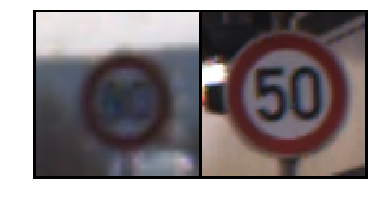

[[ 0.]]


In [35]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated),"")
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [36]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [37]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [38]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

In [39]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [40]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.966516137123108

Epoch number 0
 Current loss 5.608494281768799

Epoch number 0
 Current loss 2.707362413406372

Epoch number 0
 Current loss 2.9225614070892334

Epoch number 0
 Current loss 2.832458734512329

Epoch number 0
 Current loss 1.6904537677764893

Epoch number 0
 Current loss 0.9625430107116699

Epoch number 0
 Current loss 1.4785499572753906

Epoch number 0
 Current loss 1.0226480960845947

Epoch number 1
 Current loss 1.5609259605407715

Epoch number 1
 Current loss 1.207460880279541

Epoch number 1
 Current loss 1.6299580335617065

Epoch number 1
 Current loss 1.3151034116744995

Epoch number 1
 Current loss 1.1934897899627686

Epoch number 1
 Current loss 1.5740810632705688

Epoch number 1
 Current loss 1.4299147129058838

Epoch number 1
 Current loss 0.9646314382553101

Epoch number 1
 Current loss 1.005859136581421

Epoch number 2
 Current loss 1.2899799346923828

Epoch number 2
 Current loss 1.3134446144104004

Epoch number 2
 Current lo


Epoch number 18
 Current loss 1.180328130722046

Epoch number 18
 Current loss 1.1974283456802368

Epoch number 18
 Current loss 1.018548846244812

Epoch number 18
 Current loss 1.1255470514297485

Epoch number 19
 Current loss 1.5908689498901367

Epoch number 19
 Current loss 1.084635853767395

Epoch number 19
 Current loss 1.0914559364318848

Epoch number 19
 Current loss 1.2761085033416748

Epoch number 19
 Current loss 1.2419089078903198

Epoch number 19
 Current loss 1.1152679920196533

Epoch number 19
 Current loss 1.1418195962905884

Epoch number 19
 Current loss 0.9968367218971252

Epoch number 19
 Current loss 1.2123291492462158

Epoch number 20
 Current loss 1.1978178024291992

Epoch number 20
 Current loss 1.2393128871917725

Epoch number 20
 Current loss 1.2100205421447754

Epoch number 20
 Current loss 1.0809624195098877

Epoch number 20
 Current loss 0.9052990078926086

Epoch number 20
 Current loss 1.2179628610610962

Epoch number 20
 Current loss 1.3178794384002686

Ep


Epoch number 36
 Current loss 1.0028293132781982

Epoch number 37
 Current loss 1.1523042917251587

Epoch number 37
 Current loss 0.9221272468566895

Epoch number 37
 Current loss 1.0335091352462769

Epoch number 37
 Current loss 1.0148367881774902

Epoch number 37
 Current loss 1.3352792263031006

Epoch number 37
 Current loss 1.236871600151062

Epoch number 37
 Current loss 1.012418270111084

Epoch number 37
 Current loss 1.0717302560806274

Epoch number 37
 Current loss 1.367491364479065

Epoch number 38
 Current loss 1.1926641464233398

Epoch number 38
 Current loss 0.9782240986824036

Epoch number 38
 Current loss 1.0391194820404053

Epoch number 38
 Current loss 1.0589426755905151

Epoch number 38
 Current loss 1.0339962244033813

Epoch number 38
 Current loss 1.279819369316101

Epoch number 38
 Current loss 1.36782705783844

Epoch number 38
 Current loss 0.9163872003555298

Epoch number 38
 Current loss 1.002943992614746

Epoch number 39
 Current loss 1.1168221235275269

Epoch 


Epoch number 55
 Current loss 1.0076011419296265

Epoch number 55
 Current loss 0.9673057198524475

Epoch number 55
 Current loss 1.0184792280197144

Epoch number 55
 Current loss 1.0928486585617065

Epoch number 55
 Current loss 1.1823571920394897

Epoch number 55
 Current loss 1.1583424806594849

Epoch number 55
 Current loss 1.050765037536621

Epoch number 56
 Current loss 1.1097468137741089

Epoch number 56
 Current loss 1.0891612768173218

Epoch number 56
 Current loss 1.0829113721847534

Epoch number 56
 Current loss 0.9745231866836548

Epoch number 56
 Current loss 1.0869852304458618

Epoch number 56
 Current loss 1.1159027814865112

Epoch number 56
 Current loss 1.3396433591842651

Epoch number 56
 Current loss 0.9192919731140137

Epoch number 56
 Current loss 0.9485247135162354

Epoch number 57
 Current loss 1.241247534751892

Epoch number 57
 Current loss 1.0058987140655518

Epoch number 57
 Current loss 0.9468809962272644

Epoch number 57
 Current loss 1.2154557704925537

E


Epoch number 73
 Current loss 0.9601680636405945

Epoch number 73
 Current loss 1.0737239122390747

Epoch number 73
 Current loss 1.1563888788223267

Epoch number 73
 Current loss 1.1990100145339966

Epoch number 74
 Current loss 1.1235573291778564

Epoch number 74
 Current loss 1.0506672859191895

Epoch number 74
 Current loss 1.1644744873046875

Epoch number 74
 Current loss 0.9928361177444458

Epoch number 74
 Current loss 1.1470658779144287

Epoch number 74
 Current loss 1.159989356994629

Epoch number 74
 Current loss 1.1040139198303223

Epoch number 74
 Current loss 1.0690593719482422

Epoch number 74
 Current loss 1.0896919965744019

Epoch number 75
 Current loss 1.213911533355713

Epoch number 75
 Current loss 1.0402456521987915

Epoch number 75
 Current loss 1.191937804222107

Epoch number 75
 Current loss 0.9923888444900513

Epoch number 75
 Current loss 0.9216673374176025

Epoch number 75
 Current loss 1.1735148429870605

Epoch number 75
 Current loss 1.179686188697815

Epo


Epoch number 91
 Current loss 1.1647319793701172

Epoch number 92
 Current loss 1.1288453340530396

Epoch number 92
 Current loss 1.1475834846496582

Epoch number 92
 Current loss 1.2495040893554688

Epoch number 92
 Current loss 1.1096271276474

Epoch number 92
 Current loss 1.0736637115478516

Epoch number 92
 Current loss 1.2350903749465942

Epoch number 92
 Current loss 1.0781935453414917

Epoch number 92
 Current loss 1.1483136415481567

Epoch number 92
 Current loss 0.980415940284729

Epoch number 93
 Current loss 1.0814560651779175

Epoch number 93
 Current loss 1.1681714057922363

Epoch number 93
 Current loss 1.1072570085525513

Epoch number 93
 Current loss 1.0152748823165894

Epoch number 93
 Current loss 1.0273030996322632

Epoch number 93
 Current loss 1.0795066356658936

Epoch number 93
 Current loss 1.0754892826080322

Epoch number 93
 Current loss 1.0827690362930298

Epoch number 93
 Current loss 1.1396139860153198

Epoch number 94
 Current loss 0.9457012414932251

Epo

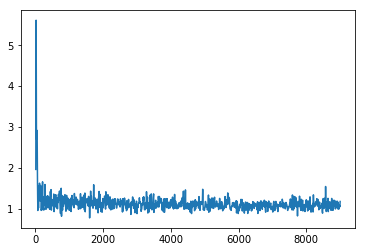

In [41]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [161]:
def histeq(im,nbr_bins=256):
    """  Histogram equalization of a grayscale image. """
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    im2 = interp(im.flatten(),bins[:-1],cdf)

    return im2.reshape(im.shape), cdf

class SiameseNetworkDatasets(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
      
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
              
                if img0_tuple[1]==img1_tuple[1]:                    
                    break
        else:
            
            img1_tuple = random.choice(self.imageFolderDataset.imgs)
           

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        #print(img1_tuple[1],img0_tuple[1])
        print(img0_tuple[0],img1_tuple[0],int(img1_tuple[1]!=img0_tuple[1]))
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

./Testing/s7\00000_00004.ppm ./Testing/s6\00000_00004.ppm 1
./Testing/s7\00000_00002.ppm ./Testing/s7\00000_00003.ppm 0

 0
[torch.FloatTensor of size 1x1]



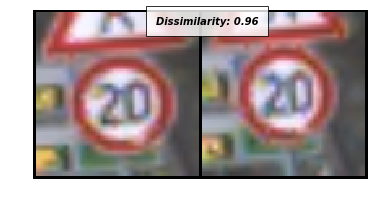

In [169]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDatasets(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(1):
    _,x1,label2 = next(dataiter)
    print(label2)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))

